<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<p> 
- Data will be in a file Train.csv <br>
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate <br>
- Size of Train.csv - 60MB <br>
- Number of rows in Train.csv = 404,290
</p>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

<h2> 3.1 Reading data and basic stats </h2>

In [2]:
df = pd.read_csv("train.csv",nrows=100000)

print("Number of data points:",df.shape[0])

Number of data points: 100000


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 6 columns):
id              100000 non-null int64
qid1            100000 non-null int64
qid2            100000 non-null int64
question1       100000 non-null object
question2       100000 non-null object
is_duplicate    100000 non-null int64
dtypes: int64(4), object(2)
memory usage: 4.6+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

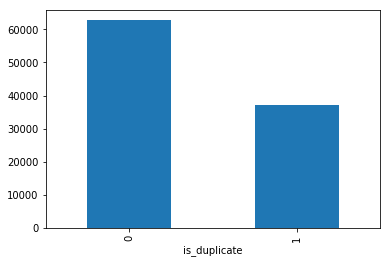

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   100000


In [7]:
len(df[df['is_duplicate']==1])

37254

In [8]:
len(df[df['is_duplicate']==0])

62746

In [9]:
len(df[df['is_duplicate']==0])/len(df['is_duplicate'])

0.62746

In [10]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   62.75%

~> Question pairs are Similar (is_duplicate = 1):
   37.25%


<h3> 3.2.2 Number of unique questions </h3>

In [11]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 165931

Number of unique questions that appear more than one time: 19446 (11.719329118730075%)

Max number of times a single question is repeated: 32



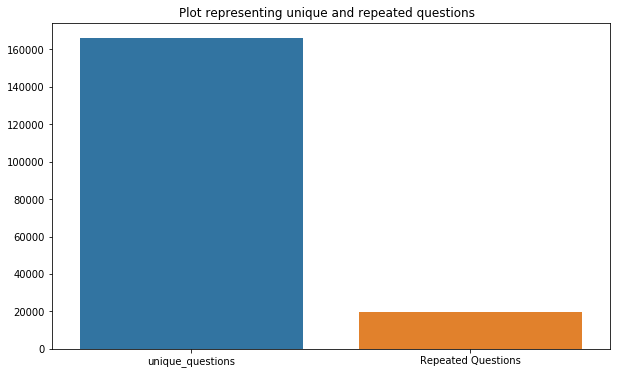

In [12]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [13]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 32



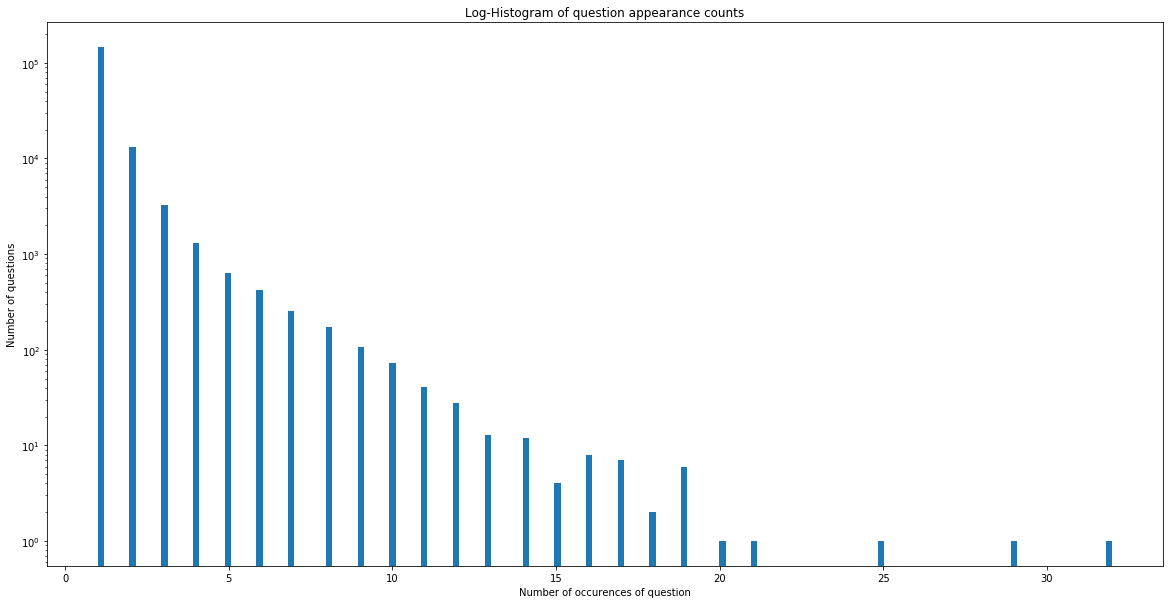

In [14]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [15]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


- There are two rows with null values in question2 and one row with null value in question1

In [16]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [17]:
if os.path.isfile('df_fe_without_preprocessing_train1.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train1.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train1.csv", index=False)

df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,1,1,76,39,13,7,2.0,20.0,0.100000,2,0


<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [18]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 15
Number of Questions with minimum length [question2] : 5


<h4> 3.3.1.1 Feature: word_share </h4>

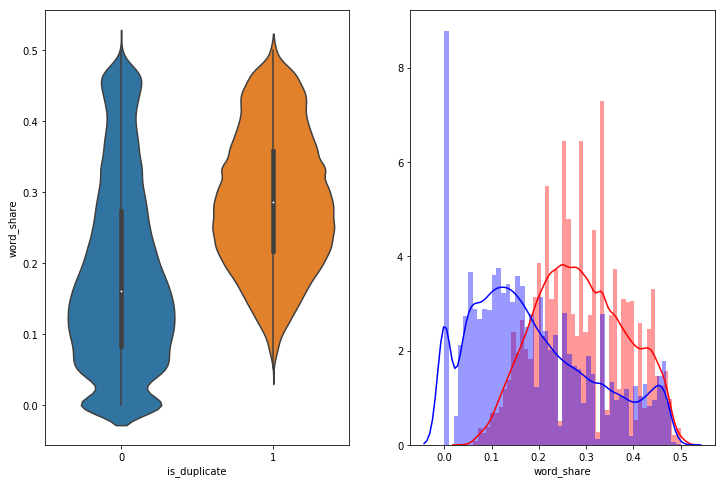

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

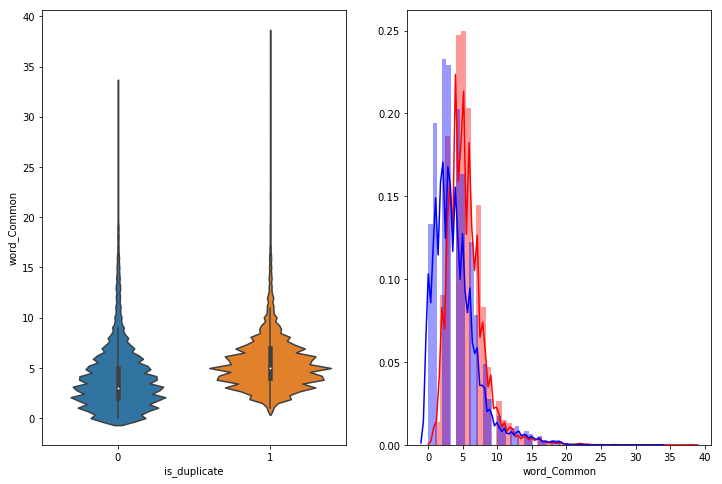

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

### 3.4 : EDA: Advanced Feature Extraction.


<h2> 3.4.1 Preprocessing of Text </h2>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [21]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will").replace("'d", " would").replace("'t", " not").replace("'m", " am")\
                           .replace(",000,000.00", "m").replace('\\n', ' ').replace('\\"', ' ').replace('\\r', ' ')
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)   
    x = re.sub('[^A-Za-z0-9]+', ' ', x)
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

<h2> 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) </h2>

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [22]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [23]:
import distance

if os.path.isfile('nlp_features_train1.csv'):
    df = pd.read_csv("nlp_features_train1.csv",encoding='latin-1')
    df.fillna('')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv",nrows=100000)
    df = extract_features(df)
    df.to_csv("nlp_features_train1.csv", index=False)
df.head(2)

Extracting features for train:
token features...
fuzzy features..


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,65,73,0.580000


<h3>3.5.1 Analysis of extracted features </h3>

<h4> 3.5.1.1 Plotting Word clouds</h4>

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [24]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,65,73,0.580000
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,63,63,43,47,0.166667
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,2.0,12.0,28,24,9,14,0.040000
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,0.307690,0.0,1.0,6.0,10.0,67,47,36,56,0.175000


In [25]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 74508
Number of data points in class 0 (non duplicate pairs) : 125492


In [26]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 4004014
Total number of words in non duplicate pair questions : 8076359


__ Word Clouds generated from  duplicate pair question's text __

In [1]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

NameError: name 'WordCloud' is not defined

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


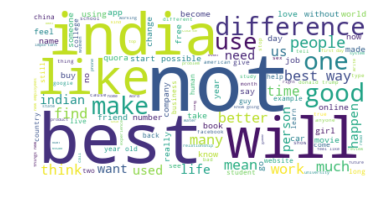

In [28]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

<h4> 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] </h4>

In [2]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

NameError: name 'df' is not defined

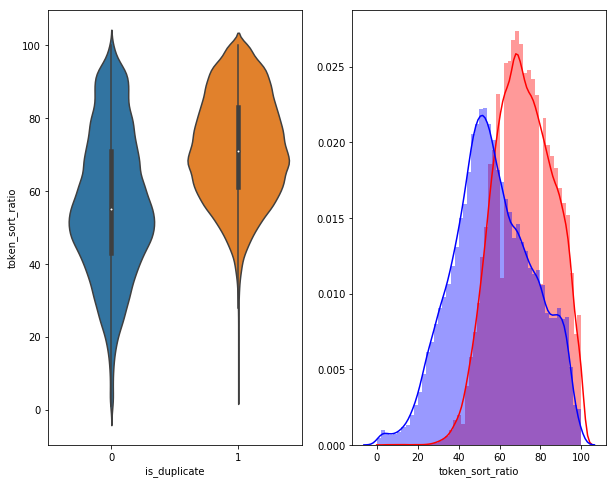

In [30]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

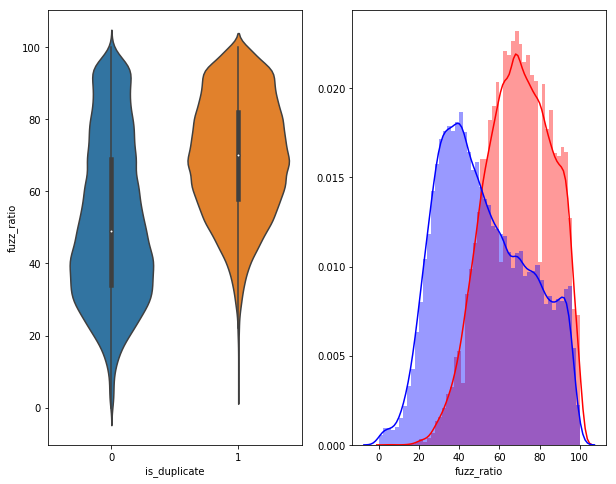

In [31]:
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'fuzz_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['fuzz_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['fuzz_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

<h3>3.5.2 Visualization </h3>

In [32]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention

from sklearn.preprocessing import MinMaxScaler

dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [33]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.444s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.131940
[t-SNE] Computed conditional probabilities in 0.248s
[t-SNE] Iteration 50: error = 81.0835876, gradient norm = 0.0426583 (50 iterations in 3.368s)
[t-SNE] Iteration 100: error = 70.5994415, gradient norm = 0.0093246 (50 iterations in 2.372s)
[t-SNE] Iteration 150: error = 68.9290848, gradient norm = 0.0060744 (50 iterations in 2.320s)
[t-SNE] Iteration 200: error = 68.1376877, gradient norm = 0.0047417 (50 iterations in 2.484s)
[t-SNE] Iteration 250: error = 67.6396408, gradient norm = 0.0032354

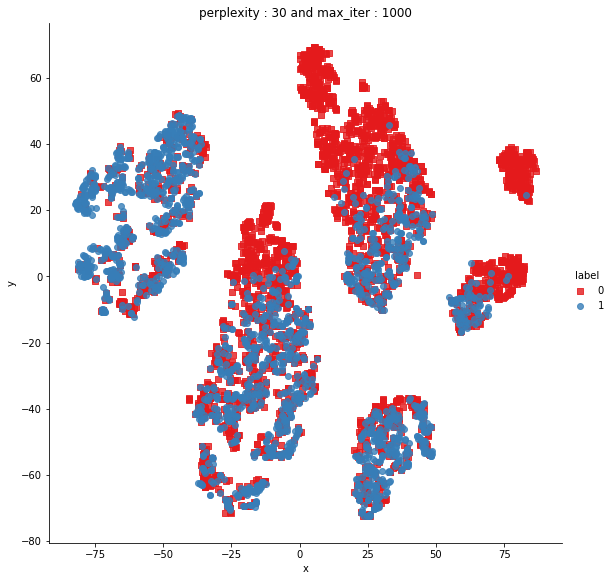

In [34]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [35]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.016s...
[t-SNE] Computed neighbors for 5000 samples in 0.452s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.131940
[t-SNE] Computed conditional probabilities in 0.240s
[t-SNE] Iteration 50: error = 80.5209732, gradient norm = 0.0294868 (50 iterations in 12.100s)
[t-SNE] Iteration 100: error = 69.4424286, gradient norm = 0.0034371 (50 iterations in 6.008s)
[t-SNE] Iteration 150: error = 68.0629730, gradient norm = 0.0017289 (50 iterations in 5.668s)
[t-SNE] Iteration 200: error = 67.4714127, gradient norm = 0.0012849 (50 iterations in 5.668s)
[t-SNE] Iteration 250: error = 67.1545105, gradient norm = 0.000936

<h2> 3.6 Featurizing text data with tfidf weighted word-vectors </h2>

In [36]:
trace1 = go.Scatter3d(
    x=tsne3d[:,0],
    y=tsne3d[:,1],
    z=tsne3d[:,2],
    mode='markers',
    marker=dict(
        sizemode='diameter',
        color = y,
        colorscale = 'Portland',
        colorbar = dict(title = 'duplicate'),
        line=dict(color='rgb(255, 255, 255)'),
        opacity=0.75
    )
)

data=[trace1]
layout=dict(height=800, width=800, title='3d embedding with engineered features')
fig=dict(data=data, layout=layout)
py.iplot(fig, filename='3DBubble')

<h2> 3.6 Featurizing text data with tfidf  </h2>

<h3> Merge "df_fe_without_preprocessing_train1" csv and "nlp_features_train1" csv features  </h3>

In [37]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train1.csv'):
    df_nlp = pd.read_csv("nlp_features_train1.csv",encoding='latin-1')
else:
    print("download nlp_features_train1.csv from drive or run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train1.csv'):
    df_fe = pd.read_csv("df_fe_without_preprocessing_train1.csv",encoding='latin-1')
else:
    print("download df_fe_without_preprocessing_train1.csv from drive or run previous notebook")

In [38]:
df_nlp.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,65,73,0.580000


In [39]:
df_fe.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,1,1,51,88,8,13,4.0,20.0,0.200000,2,0


In [40]:
df_fe = df_fe.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)


In [41]:
df_finaldata = pd.merge(df_nlp, df_fe, on='id', how='left')

In [42]:
df_finaldata.head ()

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,1,51,88,8,13,4.0,20.0,0.200000,2,0
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,why am i mentally very lonely how can i solve it,find the remainder when math 23 24 math is div...,0,0.000000,0.000000,0.000000,0.000000,...,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,which one dissolve in water quikly sugar salt ...,which fish would survive in salt water,0,0.399992,0.199998,0.999950,0.666644,...,1,76,39,13,7,2.0,20.0,0.100000,2,0


In [43]:
df_finaldata.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2'],
      dtype='object')

<h3> Preprocess Text Data  </h3>

In [44]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_qtn1 = []
# tqdm is for printing the status bar
for sentance in tqdm(df_finaldata['question1'].values):
    sent = preprocess(sentance)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_qtn1.append(sent.lower().strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:18<00:00, 5391.41it/s]


In [45]:
preprocessed_qtn2 = []
# tqdm is for printing the status bar
for sentance in tqdm(df_finaldata['question2'].values):
    sent = preprocess(sentance)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
    preprocessed_qtn2.append(sent.lower().strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:18<00:00, 5376.35it/s]


<h3> Merge above preprocessed text to final dataframe  </h3>

In [46]:
df_finaldata['preprocessed_qtn1']=preprocessed_qtn1
df_finaldata['preprocessed_qtn2']=preprocessed_qtn2

In [47]:
df_finaldata.head(2)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,preprocessed_qtn1,preprocessed_qtn2
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,57,14,12,10.0,23.0,0.434783,2,0,step step guide invest share market india,step step guide invest share market
1,1,3,4,what is the story of kohinoor koh i noor diamond,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,88,8,13,4.0,20.0,0.200000,2,0,story kohinoor koh noor diamond,happen indian government stole kohinoor koh no...


<h2>3.6.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [48]:
# extract data column project_is_approved from total_project_data and add it to variable y
# remove project_is_approved from total_project_data and store the data in to variable X
y = df_finaldata['is_duplicate'].values
df_finaldata.drop(['is_duplicate'], axis=1, inplace=True)
df_finaldata.drop(['question1','question2','qid1','qid2'], axis=1, inplace=True)
X = df_finaldata
X.head(1)

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,preprocessed_qtn1,preprocessed_qtn2
0,0,0.99998,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,...,57,14,12,10.0,23.0,0.434783,2,0,step step guide invest share market india,step step guide invest share market


In [49]:
#split the data in to train and cross validation and test before performing BOW, TFIDF
# train test split
from sklearn.model_selection import train_test_split
#splitting data in to train and test with 33 percentage as test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [50]:
#print after split data in to train, cv and test
print("Number of data points in X_train data", X_train.shape)
print('-'*50)
print("Number of data points in X_test data", X_test.shape)
print('-'*50)
print("Number of data points in Y_train data", y_train.shape)
print('-'*50)
print("Number of data points in Y_test data", y_test.shape)
print('-'*50)

Number of data points in X_train data (70000, 29)
--------------------------------------------------
Number of data points in X_test data (30000, 29)
--------------------------------------------------
Number of data points in Y_train data (70000,)
--------------------------------------------------
Number of data points in Y_test data (30000,)
--------------------------------------------------


<h2>3.6.2. Make Data Model Ready: encoding eassay</h2>

<h3>Vectorizing Text data</h3>

<h3>Encoding Text data: Question1 (TFIDF) </h3>

In [51]:
X_train.head()

,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,preprocessed_qtn1,preprocessed_qtn2
52751,52751,0.666644,0.666644,0.999900,0.999900,0.749981,0.749981,1.0,1.0,0.0,...,15,3,4,2.0,7.0,0.285714,2,0,5 6 short,5 2 short
5485,5485,0.799992,0.727266,0.833319,0.833319,0.722218,0.684207,0.0,0.0,1.0,...,89,16,15,10.0,29.0,0.344828,2,0,non us citizen non resident open bank account ...,united states non us citizen non resident set ...
18628,18628,0.666644,0.333328,0.333328,0.333328,0.444440,0.307690,0.0,1.0,4.0,...,68,9,13,2.0,21.0,0.095238,2,0,experience project application,ideas web application final year project
82024,82024,0.999900,0.499975,0.000000,0.000000,0.333322,0.199996,0.0,0.0,2.0,...,25,3,5,0.0,8.0,0.000000,3,1,fistula,fistula cure
51372,51372,0.666656,0.571420,0.000000,0.000000,0.363633,0.363633,1.0,0.0,0.0,...,69,11,11,4.0,21.0,0.190476,9,3,win ugc net exam english literature,best preparation strategy ugc net english lite...


In [52]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train["preprocessed_qtn1"]) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_qt1_tfidf = vectorizer.transform(X_train["preprocessed_qtn1"])
X_test_qt1_tfidf = vectorizer.transform(X_test["preprocessed_qtn1"])

print("After vectorizations")
print(X_train_qt1_tfidf.shape, y_train.shape)
print(X_test_qt1_tfidf.shape, y_test.shape)
print("="*100)

(70000, 29) (70000,)
(30000, 29) (30000,)
After vectorizations
(70000, 5000) (70000,)
(30000, 5000) (30000,)


<h3>Encoding Text data: Question2(TFIDF) </h3>

In [53]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print("="*100)


vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train["preprocessed_qtn2"]) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_qt2_tfidf = vectorizer.transform(X_train["preprocessed_qtn2"])
X_test_qt2_tfidf = vectorizer.transform(X_test["preprocessed_qtn2"])

print("After vectorizations")
print(X_train_qt2_tfidf.shape, y_train.shape)
print(X_test_qt2_tfidf.shape, y_test.shape)
print("="*100)

(70000, 29) (70000,)
(30000, 29) (30000,)
After vectorizations
(70000, 5000) (70000,)
(30000, 5000) (30000,)


<h1>4. Machine Learning Models </h1>

#### Merge matrices

In [54]:
X_train.columns

Index(['id', 'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio', 'freq_qid1', 'freq_qid2',
       'q1len', 'q2len', 'q1_n_words', 'q2_n_words', 'word_Common',
       'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'preprocessed_qtn1', 'preprocessed_qtn2'],
      dtype='object')

In [55]:
X_train=X_train.drop(['id','preprocessed_qtn1','preprocessed_qtn2'],axis=1)
X_train.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
52751,0.666644,0.666644,0.999900,0.999900,0.749981,0.749981,1.0,1.0,0.0,4.0,...,1,13,15,3,4,2.0,7.0,0.285714,2,0
5485,0.799992,0.727266,0.833319,0.833319,0.722218,0.684207,0.0,0.0,1.0,18.5,...,1,98,89,16,15,10.0,29.0,0.344828,2,0


In [56]:
X_test=X_test.drop(['id','preprocessed_qtn1','preprocessed_qtn2'],axis=1)
X_test.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
35371,0.000000,0.000000,0.666644,0.222220,0.333328,0.124999,0.0,0.0,10.0,11.0,...,1,77,32,16,6,2.0,22.0,0.090909,2,0
3340,0.999967,0.749981,0.999967,0.599988,0.999983,0.599994,1.0,1.0,4.0,8.0,...,1,45,30,10,6,6.0,15.0,0.400000,2,0


In [57]:

from scipy import sparse

X_tfidf_tr = sparse.hstack((X_train_qt2_tfidf,X_train_qt1_tfidf,X_train.values)).tocsr()
X_tfidf_te = sparse.hstack((X_test_qt2_tfidf,X_test_qt1_tfidf,X_test.values)).tocsr()

print("Final Data matrix")
print(X_tfidf_tr.shape, y_train.shape)
print(X_tfidf_te.shape, y_test.shape)
print("="*100)


Final Data matrix
(70000, 10026) (70000,)
(30000, 10026) (30000,)


<h2> 4.1 Building a random model (Finding worst-case log-loss) </h2>

In [58]:
from collections import Counter
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[0])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6274571428571428 Class 1:  0.3725428571428571
---------- Distribution of output variable in train data ----------
Class 0:  0.6274666666666666 Class 1:  0.3725333333333333


In [59]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.8804244687276812


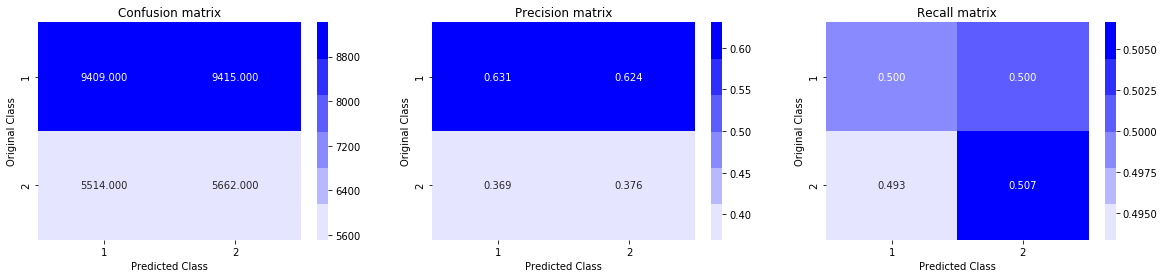

In [60]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.metrics import confusion_matrix
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))
predicted_y1 =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y1)

<h2> 4.2 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4413548597661514
For values of alpha =  0.0001 The log loss is: 0.438838470378385
For values of alpha =  0.001 The log loss is: 0.4656172353041772
For values of alpha =  0.01 The log loss is: 0.4878344241005955
For values of alpha =  0.1 The log loss is: 0.5114655936472285
For values of alpha =  1 The log loss is: 0.5386994639238621
For values of alpha =  10 The log loss is: 0.586047254363957


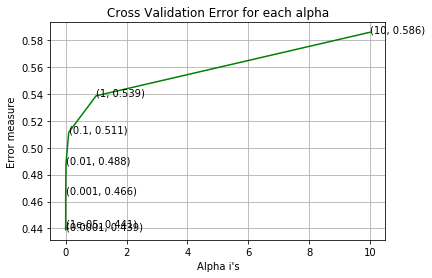

For values of best alpha =  0.0001 The train log loss is: 0.43541204643765546
For values of best alpha =  0.0001 The test log loss is: 0.438838470378385
Total number of data points : 30000


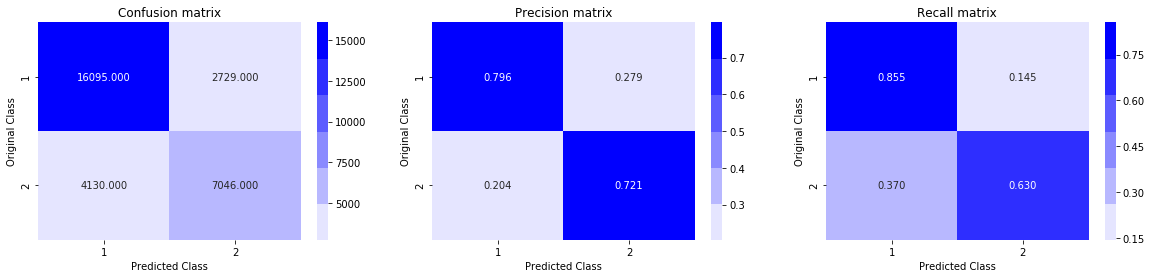

In [61]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, ve rbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array_logistic=[]
for i in alpha:
    clf_logistic = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42,n_jobs=-1)
    clf_logistic.fit(X_tfidf_tr, y_train)
    sig_clf_logistic = CalibratedClassifierCV(clf_logistic, method="sigmoid")
    sig_clf_logistic.fit(X_tfidf_tr, y_train)
    predict_y_logistic = sig_clf_logistic.predict_proba(X_tfidf_te)
    log_error_array_logistic.append(log_loss(y_test, predict_y_logistic, labels=clf_logistic.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y_logistic, labels=clf_logistic.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array_logistic,c='g')
for i, txt in enumerate(np.round(log_error_array_logistic,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array_logistic[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_logistic = np.argmin(log_error_array_logistic)
clf_logistic = SGDClassifier(alpha=alpha[best_alpha_logistic], penalty='l2', loss='log', random_state=42,n_jobs=-1)
clf_logistic.fit(X_tfidf_tr, y_train)
sig_clf_logistic = CalibratedClassifierCV(clf_logistic, method="sigmoid")
sig_clf_logistic.fit(X_tfidf_tr, y_train)

predict_y_logistic = sig_clf_logistic.predict_proba(X_tfidf_tr)
print('For values of best alpha = ', alpha[best_alpha_logistic], "The train log loss is:",log_loss(y_train, predict_y_logistic, labels=clf_logistic.classes_, eps=1e-15))
predict_y_logistic = sig_clf_logistic.predict_proba(X_tfidf_te)
print('For values of best alpha = ', alpha[best_alpha_logistic], "The test log loss is:",log_loss(y_test, predict_y_logistic, labels=clf_logistic.classes_, eps=1e-15))
predicted_y_logistic =np.argmax(predict_y_logistic,axis=1)
print("Total number of data points :", len(predicted_y_logistic))
plot_confusion_matrix(y_test, predicted_y_logistic)

<h2> 4.3 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.4655193013762306
For values of alpha =  0.0001 The log loss is: 0.4842717085810649
For values of alpha =  0.001 The log loss is: 0.5082600422314115
For values of alpha =  0.01 The log loss is: 0.5185205691006692
For values of alpha =  0.1 The log loss is: 0.5297450553185363
For values of alpha =  1 The log loss is: 0.6435386578045611
For values of alpha =  10 The log loss is: 0.6245970189547654


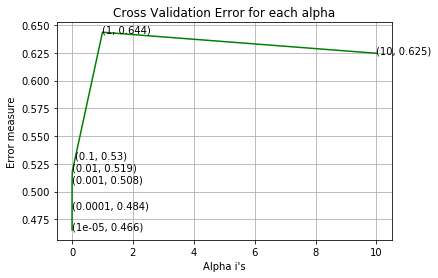

For values of best alpha =  1e-05 The train log loss is: 0.4610327445182175
For values of best alpha =  1e-05 The test log loss is: 0.4655193013762306
Total number of data points : 30000


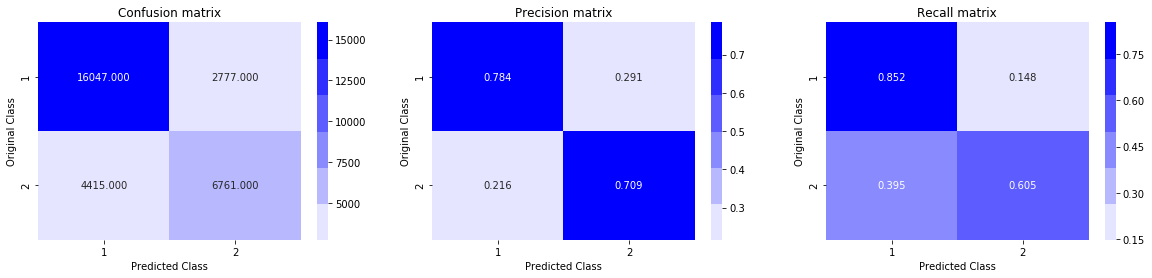

In [62]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.


log_error_array_svm=[]
for i in alpha:
    clf_svm = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42,n_jobs=-1)
    clf_svm.fit(X_tfidf_tr, y_train)
    sig_clf_svm = CalibratedClassifierCV(clf_svm, method="sigmoid")
    sig_clf_svm.fit(X_tfidf_tr, y_train)
    predict_y_svm = sig_clf_svm.predict_proba(X_tfidf_te)
    log_error_array_svm.append(log_loss(y_test, predict_y_svm, labels=clf_svm.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y_svm, labels=clf_svm.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array_svm,c='g')
for i, txt in enumerate(np.round(log_error_array_svm,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array_svm[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha_svm = np.argmin(log_error_array_svm)
clf_svm = SGDClassifier(alpha=alpha[best_alpha_svm], penalty='l1', loss='hinge', random_state=42,n_jobs=-1)
clf_svm.fit(X_tfidf_tr, y_train)
sig_clf_svm = CalibratedClassifierCV(clf_svm, method="sigmoid")
sig_clf_svm.fit(X_tfidf_tr, y_train)

predict_y_svm = sig_clf_svm.predict_proba(X_tfidf_tr)
print('For values of best alpha = ', alpha[best_alpha_svm], "The train log loss is:",log_loss(y_train, predict_y_svm, labels=clf_svm.classes_, eps=1e-15))
predict_y_svm = sig_clf_svm.predict_proba(X_tfidf_te)
print('For values of best alpha = ', alpha[best_alpha_svm], "The test log loss is:",log_loss(y_test, predict_y_svm, labels=clf_svm.classes_, eps=1e-15))
predicted_y_svm =np.argmax(predict_y_svm,axis=1)
print("Total number of data points :", len(predicted_y_svm))
plot_confusion_matrix(y_test, predicted_y_svm)

<h2> 4.4 XGBoost </h2>

In [63]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

parametersK = {'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],'n_estimators':[10, 50, 100, 150, 200, 300, 500, 1000],'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]}
tfidf_GBneigh = RandomizedSearchCV(xgb.XGBClassifier(), param_distributions=parametersK, cv=3, n_iter=30,scoring = 'neg_log_loss',n_jobs=-1)
tfidf_GBneigh.fit(X_tfidf_tr,y_train)
tfidf_GBneigh.cv_results_

{'mean_fit_time': array([ 23.67864505, 132.02123014, 633.46847995,  15.79213603,
         75.49929849, 127.58443181, 105.38639784, 106.10057823,
        652.96424747,   6.24734465,  58.57103117,   4.0448459 ,
         97.04239233,  54.58414348, 184.16013145,  44.0576791 ,
        171.63646007,   4.10645628,   5.16905363, 216.23659499,
         93.86320003, 107.0813086 , 227.93846337, 567.73353434,
         61.59318884, 802.90115086,  37.87171833, 195.98123113,
         86.77875519,  56.26903709]),
 'std_fit_time': array([7.24678555e-02, 2.76778976e+00, 2.29491971e+01, 5.03115063e-01,
        1.67713592e+00, 8.05651274e+00, 3.63211698e+00, 3.20283480e+00,
        4.68216634e+00, 1.12267612e-01, 1.55314086e-01, 8.31793645e-03,
        7.54816987e-01, 8.24025721e-02, 2.12968295e-01, 2.01970294e-01,
        1.04837363e+00, 2.20893121e-02, 3.25822954e-02, 2.36735034e+01,
        1.52465721e+01, 3.11478410e+00, 2.42087392e+00, 2.12755689e+00,
        2.11019710e+00, 8.01725638e+00, 1.2947573

In [64]:
tfidf_GBneigh.best_params_

{'n_estimators': 500, 'max_depth': 10, 'learning_rate': 0.1}

In [65]:
X_tfidf_tr

<70000x10026 sparse matrix of type '<class 'numpy.float64'>'
	with 2336931 stored elements in Compressed Sparse Row format>

Train Log Loss:0.20640751839663496Test Log Loss:0.34958138205605105


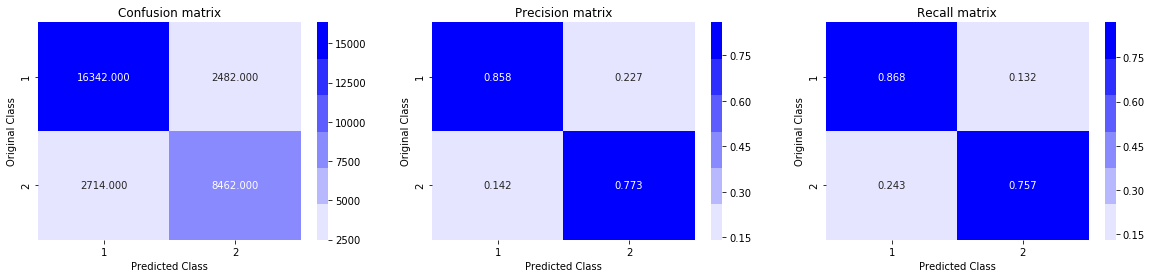

In [66]:
clf_xGB1 = xgb.XGBClassifier(max_depth=10 , n_estimators=1000, learning_rate=0.1 , n_jobs=-1)
clf_xGB1.fit(X_tfidf_tr,y_train)
predict_y_test_xGB = clf_xGB1.predict_proba(X_tfidf_te)
predict_y_train_xGB=clf_xGB1.predict_proba(X_tfidf_tr)
log_xgb_loss_train=log_loss(y_train, predict_y_train_xGB, labels=clf_xGB1.classes_, eps=1e-15)
log_xgb_loss_test=log_loss(y_test, predict_y_test_xGB, labels=clf_xGB1.classes_, eps=1e-15)
print("Train Log Loss:"+str(log_xgb_loss_train)+"Test Log Loss:"+str(log_xgb_loss_test))
predicted_y_xgb =np.argmax(predict_y_test_xGB,axis=1)

plot_confusion_matrix(y_test, predicted_y_xgb)

<h2>5. XGBOOST using TFIDFW2V </h2>

<h2>5.1 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [68]:
#split the data in to train and cross validation and test before performing BOW, TFIDF
# train test split
from sklearn.model_selection import train_test_split
#splitting data in to train and test with 33 percentage as test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [69]:
#print after split data in to train, cv and test
print("Number of data points in X_train data", X_train.shape)
print('-'*50)
print("Number of data points in X_test data", X_test.shape)
print('-'*50)
print("Number of data points in Y_train data", y_train.shape)
print('-'*50)
print("Number of data points in Y_test data", y_test.shape)
print('-'*50)

Number of data points in X_train data (70000, 29)
--------------------------------------------------
Number of data points in X_test data (30000, 29)
--------------------------------------------------
Number of data points in Y_train data (70000,)
--------------------------------------------------
Number of data points in Y_test data (30000,)
--------------------------------------------------


In [70]:
#replacing null column values with some dummy data to avoid errors during calculating TFIDFW2v
X_train['preprocessed_qtn1']=X_train['preprocessed_qtn1'].replace('', "Dummy Data")
X_train['preprocessed_qtn2']=X_train['preprocessed_qtn2'].replace('', "Dummy Data1")
X_test['preprocessed_qtn1']=X_test['preprocessed_qtn1'].replace('', "Dummy Data3")
X_test['preprocessed_qtn2']=X_test['preprocessed_qtn2'].replace('', "Dummy Data4")
X_train.head(2)


,id,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,...,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,preprocessed_qtn1,preprocessed_qtn2
48587,48587,0.999950,0.999950,0.99995,0.666644,0.999975,0.799984,1.0,1.0,1.0,...,25,4,4,2.0,8.0,0.250000,2,0,butterfly effect,butterfly effect
97857,97857,0.999967,0.374995,0.00000,0.000000,0.499992,0.230767,0.0,0.0,7.0,...,32,13,6,2.0,19.0,0.105263,7,1,best way start learning c language within month,start learning c


<h2>5.2. Make Data Model Ready: encoding eassay</h2>

<h3>Vectorizing Text data</h3>

<h3>Encoding Text data: Question1 (TFIDFW2V) </h3>

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# merge texts
X_train_questions_1 = list(X_train['preprocessed_qtn1']) + list(X_train['preprocessed_qtn2'])

X_train_tfidf_1 = TfidfVectorizer(lowercase=False, )
X_train_tfidf_1.fit_transform(X_train_questions_1)

# dict key:word and value:tf-idf score
word2tfidf = dict(zip(X_train_tfidf_1.get_feature_names(), X_train_tfidf_1.idf_))

In [72]:
import spacy
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

X_train_vecs1_1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['preprocessed_qtn1'])):
    #print(qu1)
    X_train_doc1_1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    #print (len(X_train_doc1_1))
    #print(len(X_train_doc1_1[0].vector))
    X_train_mean_vec1_1 = np.zeros([len(X_train_doc1_1), len(X_train_doc1_1[0].vector)])
    for X_train_word1_1 in X_train_doc1_1:
        # word2vec
        vec1 = X_train_word1_1.vector
        # fetch X_train score
        try:
            iX_train_1 = X_train_word2tfidf_1[str(X_train_word1_1)]
        except:
            iX_train_1 = 0
        # compute final vec
        X_train_mean_vec1_1 += vec1 * iX_train_1
    X_train_mean_vec1_1 = X_train_mean_vec1_1.mean(axis=0)
    X_train_vecs1_1.append(X_train_mean_vec1_1)

#X_train['X_train_q1_feats_m_1'] = list(X_train_vecs1_1)

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [11:31<00:00, 101.19it/s]


In [73]:
import spacy
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

X_train_vecs1_2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_train['preprocessed_qtn2'])):
    X_train_doc1_2 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    X_train_mean_vec1_2 = np.zeros([len(X_train_doc1_2), len(X_train_doc1_2[0].vector)])
    for X_train_word1_2 in X_train_doc1_2:
        # word2vec
        vec1 = X_train_word1_2.vector
        # fetch X_train score
        try:
            iX_train_2 = X_train_word2tfidf_1[str(X_train_word1_2)]
        except:
            iX_train_2 = 0
        # compute final vec
        X_train_mean_vec1_2 += vec1 * iX_train_2
    X_train_mean_vec1_2 = X_train_mean_vec1_2.mean(axis=0)
    X_train_vecs1_2.append(X_train_mean_vec1_2)
    
#X_train['X_train_q1_feats_m_2'] = list(X_train_vecs1_2)

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [11:20<00:00, 102.80it/s]


In [74]:
import spacy
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

X_test_vecs1_1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['preprocessed_qtn1'])):
    X_test_doc1_1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    X_test_mean_vec1_1 = np.zeros([len(X_test_doc1_1), len(X_test_doc1_1[0].vector)])
    for X_test_word1_1 in X_test_doc1_1:
        # word2vec
        vec1 = X_test_word1_1.vector
        # fetch X_test score
        try:
            iX_test_1 = X_train_word2tfidf_1[str(X_test_word1_1)]
        except:
            iX_test_1 = 0
        # compute final vec
        X_test_mean_vec1_1 += vec1 * iX_test_1
    X_test_mean_vec1_1 = X_test_mean_vec1_1.mean(axis=0)
    X_test_vecs1_1.append(X_test_mean_vec1_1)
#X_test['X_test_q1_feats_m_1'] = list(X_test_vecs1_1)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [04:52<00:00, 102.71it/s]


In [75]:
import spacy
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

X_test_vecs1_2 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(X_test['preprocessed_qtn2'])):
    X_test_doc1_2 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    X_test_mean_vec1_2 = np.zeros([len(X_test_doc1_2), len(X_test_doc1_2[0].vector)])
    for X_test_word1_2 in X_test_doc1_2:
        # word2vec
        vec1 = X_test_word1_2.vector
        # fetch X_test score
        try:
            iX_test_2 = X_train_word2tfidf_1[str(X_test_word1_2)]
        except:
            iX_test_2 = 0
        # compute final vec
        X_test_mean_vec1_2 += vec1 * iX_test_2
    X_test_mean_vec1_2 = X_test_mean_vec1_2.mean(axis=0)
    X_test_vecs1_2.append(X_test_mean_vec1_2)
#X_test['X_test_q1_feats_m_2'] = list(X_test_vecs1_2)

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [04:46<00:00, 104.70it/s]


In [76]:
X_train=X_train.drop(['id','preprocessed_qtn1','preprocessed_qtn2'],axis=1)
X_train.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
48587,0.999950,0.999950,0.99995,0.666644,0.999975,0.799984,1.0,1.0,1.0,4.5,...,1,28,25,4,4,2.0,8.0,0.250000,2,0
97857,0.999967,0.374995,0.00000,0.000000,0.499992,0.230767,0.0,0.0,7.0,9.5,...,3,65,32,13,6,2.0,19.0,0.105263,7,1


In [77]:
X_test=X_test.drop(['id','preprocessed_qtn1','preprocessed_qtn2'],axis=1)
X_test.head(2)

,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,...,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
15926,0.999983,0.999983,0.999980,0.833319,0.999991,0.916659,1.0,1.0,1.0,11.5,...,1,72,76,11,12,11.0,23.0,0.478261,2,0
61583,0.499988,0.499988,0.499975,0.499975,0.499992,0.499992,0.0,0.0,0.0,6.0,...,1,41,40,6,6,3.0,12.0,0.250000,2,0


In [78]:

from scipy import sparse

X_tfidfw2v_tr = sparse.hstack((X_train_vecs1_2,X_train_vecs1_1,X_train)).tocsr()
X_tfidfw2v_te = sparse.hstack((X_test_vecs1_2,X_test_vecs1_1,X_test)).tocsr()

print("Final Data matrix")
print(X_tfidfw2v_tr.shape, y_train.shape)
print(X_tfidfw2v_te.shape, y_test.shape)
print("="*100)


Final Data matrix
(70000, 218) (70000,)
(30000, 218) (30000,)


<h2> 5.3 XGBoost </h2>

In [79]:
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

parametersK = {'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, 10],'n_estimators':[10, 50, 100, 150, 200, 300, 500, 1000],'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3]}
tfidfw2v_GBneigh = RandomizedSearchCV(xgb.XGBClassifier(), param_distributions=parametersK, cv=3, n_iter=30,scoring = 'neg_log_loss',n_jobs=-1)
tfidfw2v_GBneigh.fit(X_tfidfw2v_tr,y_train)
tfidfw2v_GBneigh.cv_results_

c:\users\user\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning:

The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.



{'mean_fit_time': array([276.84933925, 205.77178868,  59.57638526, 290.79058369,
        142.77721453,  24.8823634 , 257.19151251, 170.62124705,
        239.32664227, 120.35357515, 494.70215917,   4.55016263,
         18.52130493,  16.82701111,   2.53056367,  39.49720605,
          4.42981752,  10.83199366, 418.70475753,  85.26811043,
          3.86401685,   6.8426973 ,  17.83480342,  50.15504376,
         86.69326377,  45.21263909, 100.63216949,  30.37236182,
         49.37860537,   2.10603261]),
 'std_fit_time': array([8.14406066e-01, 3.42869944e+00, 2.63829192e-01, 1.35138544e+00,
        1.45553813e+00, 2.47381672e-01, 3.35621484e-01, 7.42858444e+00,
        1.15636411e+00, 1.10463117e+00, 1.27190772e+00, 4.41489915e-01,
        1.54662279e+00, 3.34297242e-01, 4.09861095e-03, 1.01867844e-02,
        3.31023407e-02, 4.31129336e-02, 3.90759227e-01, 1.61285311e+01,
        1.17890654e-02, 1.41281425e-02, 1.24112426e-01, 4.65480715e-01,
        1.29686097e-01, 2.47317846e-01, 2.8381558

In [80]:
tfidfw2v_GBneigh.best_params_

{'n_estimators': 100, 'max_depth': 8, 'learning_rate': 0.1}

In [ ]:
X_tfidfw2v_tr

Train Log Loss:0.3251421002525021Test Log Loss:0.37398792097152644


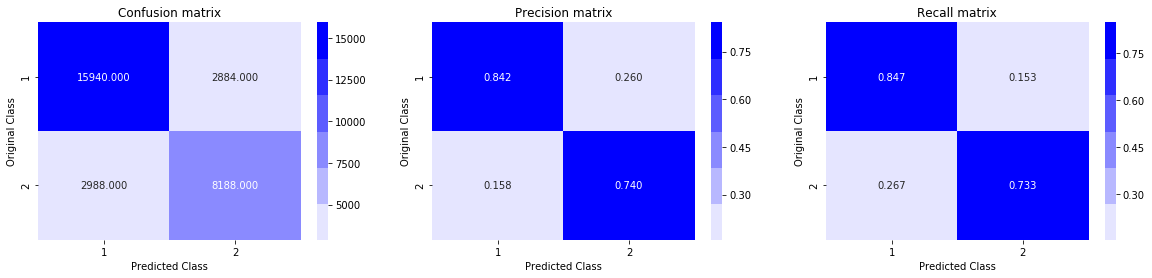

In [81]:
clf_tfidfw2v_xGB1 = xgb.XGBClassifier(max_depth=8 , n_estimators=100, learning_rate=0.1 , n_jobs=-1)
clf_tfidfw2v_xGB1.fit(X_tfidfw2v_tr,y_train)
predict_y_test_xGB = clf_tfidfw2v_xGB1.predict_proba(X_tfidfw2v_te)
predict_y_train_xGB=clf_tfidfw2v_xGB1.predict_proba(X_tfidfw2v_tr)
log_xgb_loss_train=log_loss(y_train, predict_y_train_xGB, labels=clf_tfidfw2v_xGB1.classes_, eps=1e-15)
log_xgb_loss_test=log_loss(y_test, predict_y_test_xGB, labels=clf_tfidfw2v_xGB1.classes_, eps=1e-15)
print("Train Log Loss:"+str(log_xgb_loss_train)+"Test Log Loss:"+str(log_xgb_loss_test))
predicted_y_xgb =np.argmax(predict_y_test_xGB,axis=1)

plot_confusion_matrix(y_test, predicted_y_xgb)

<h1>6. Conclusion</h1>

In [85]:
from prettytable import PrettyTable
    
Finaloutput = PrettyTable()

Finaloutput.field_names = ["Vectorizer", "Model", "Train Log Loss","Test Log Loss"]

Finaloutput.add_row(["Random", "Random Model","","0.8804244687276812"])
Finaloutput.add_row(["TFIDF", "Logistic Regression","0.43541204643765546","0.438838470378385"])
Finaloutput.add_row(["TFIDF", "Linear SVM","0.4610327445182175","0.4655193013762306"])
Finaloutput.add_row(["TFIDF", "XGBOOST","0.20640751839663496","0.34958138205605105"])
Finaloutput.add_row(["TFIDFW2V", "XGBOOST","0.3251421002525021","0.37398792097152644"])
print(Finaloutput)

+------------+---------------------+---------------------+---------------------+
| Vectorizer |        Model        |    Train Log Loss   |    Test Log Loss    |
+------------+---------------------+---------------------+---------------------+
|   Random   |     Random Model    |                     |  0.8804244687276812 |
|   TFIDF    | Logistic Regression | 0.43541204643765546 |  0.438838470378385  |
|   TFIDF    |      Linear SVM     |  0.4610327445182175 |  0.4655193013762306 |
|   TFIDF    |       XGBOOST       | 0.20640751839663496 | 0.34958138205605105 |
|  TFIDFW2V  |       XGBOOST       |  0.3251421002525021 | 0.37398792097152644 |
+------------+---------------------+---------------------+---------------------+


## Observation
<p> Considered only 100000 data points to measure performance metric (Log Loss)</p>
<p> XGBOOST with TFIDF vectorizer have given best results of "Log Loss" compared with other models</p>
<p> Logistic Regression with TFIDF vectorizer has given second best results of "Log Loss" compared with other models</p>